In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf
import keras
from matplotlib import rcParams
rcParams['figure.figsize']=10,6
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import h5py

In [3]:
dataset = pd.read_csv(r"C:\Prediction Project\Weather\rainfall in india 1901-2015.csv", encoding="ISO-8859-1")
dataset.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [4]:
groups = dataset.groupby('SUBDIVISION')[['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'NOV', 'DEC']]
data = groups.get_group(('BIHAR'))
data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,NOV,DEC
897,1901,51.8,19.6,11.9,1.1,65.6,66.3,245.9,319.4,155.1,7.3,0.1
898,1902,4.6,0.7,24.3,17.3,66.3,118.2,361.0,225.5,358.7,1.1,0.0
899,1903,5.3,4.7,2.0,4.7,28.2,192.9,115.0,342.6,173.9,0.1,0.0
900,1904,6.3,1.7,3.5,5.3,118.7,191.6,394.4,351.3,84.4,10.6,3.8
901,1905,16.0,30.1,32.6,21.4,77.5,50.5,409.1,495.3,353.9,0.0,0.6


In [5]:
data = data.melt(['YEAR']).reset_index()
data.head()

,index,YEAR,variable,value
0,0,1901,JAN,51.8
1,1,1902,JAN,4.6
2,2,1903,JAN,5.3
3,3,1904,JAN,6.3
4,4,1905,JAN,16.0


In [6]:
df = data[['YEAR', 'variable', 'value']].reset_index().sort_values(by=['YEAR', 'index'])
df.head()

,index,YEAR,variable,value
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [7]:
df.columns=['INDEX','YEAR','Month','avg_rainfall']
df.head()

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [8]:
d={'JAN':1,'FEB':2,'MAR' :3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,
   'OCT':10,'NOV':11,'DEC':12}
df['Month']=df['Month'].map(d)
df.head(12)

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,1,51.8
115,115,1901,2,19.6
230,230,1901,3,11.9
345,345,1901,4,1.1
460,460,1901,5,65.6
575,575,1901,6,66.3
690,690,1901,7,245.9
805,805,1901,8,319.4
920,920,1901,9,155.1
1035,1035,1901,11,7.3


In [9]:
df['Date']=pd.to_datetime(df.assign(Day=1).loc[:,['YEAR','Month','Day']])
df.head(12)

,INDEX,YEAR,Month,avg_rainfall,Date
0,0,1901,1,51.8,1901-01-01
115,115,1901,2,19.6,1901-02-01
230,230,1901,3,11.9,1901-03-01
345,345,1901,4,1.1,1901-04-01
460,460,1901,5,65.6,1901-05-01
575,575,1901,6,66.3,1901-06-01
690,690,1901,7,245.9,1901-07-01
805,805,1901,8,319.4,1901-08-01
920,920,1901,9,155.1,1901-09-01
1035,1035,1901,11,7.3,1901-11-01


In [10]:
dataset = df[['avg_rainfall']]

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_raw = dataset.values.astype("float32")
dataset = scaler.fit_transform(data_raw)

In [12]:
TRAIN_SIZE = 0.80
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [13]:
def create_dataset(dataset, window_size=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return np.array(data_X), np.array(data_Y)

In [14]:
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [15]:
def fit_model(train_X, train_Y, window_size=1):
    model = Sequential()
    model.add(LSTM(2000, activation='tanh', recurrent_activation='hard_sigmoid', input_shape=(window_size, train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(train_X, train_Y, epochs=10, batch_size=64, validation_split=0.2)
    return model

In [16]:
model = fit_model(train_X, train_Y, window_size)

Epoch 1/10
13/13 [==============================] - 8s 304ms/step - loss: 0.0454 - val_loss: 0.0412
Epoch 2/10
13/13 [==============================] - 3s 257ms/step - loss: 0.0338 - val_loss: 0.0398
Epoch 3/10
13/13 [==============================] - 3s 257ms/step - loss: 0.0344 - val_loss: 0.0377
Epoch 4/10
13/13 [==============================] - 3s 270ms/step - loss: 0.0326 - val_loss: 0.0359
Epoch 5/10
13/13 [==============================] - 4s 273ms/step - loss: 0.0337 - val_loss: 0.0371
Epoch 6/10
13/13 [==============================] - 4s 281ms/step - loss: 0.0331 - val_loss: 0.0359
Epoch 7/10
13/13 [==============================] - 4s 277ms/step - loss: 0.0305 - val_loss: 0.0348
Epoch 8/10
13/13 [==============================] - 4s 275ms/step - loss: 0.0321 - val_loss: 0.0360
Epoch 9/10
13/13 [==============================] - 4s 273ms/step - loss: 0.0325 - val_loss: 0.0331
Epoch 10/10
13/13 [==============================] - 3s 266ms/step - loss: 0.0308 - val_loss: 0.0335

In [17]:
model.save('model.h5')

C:\Users\oscur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return score, pred

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

8/8 [==============================] - 0s 13ms/step


In [19]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

In [20]:
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

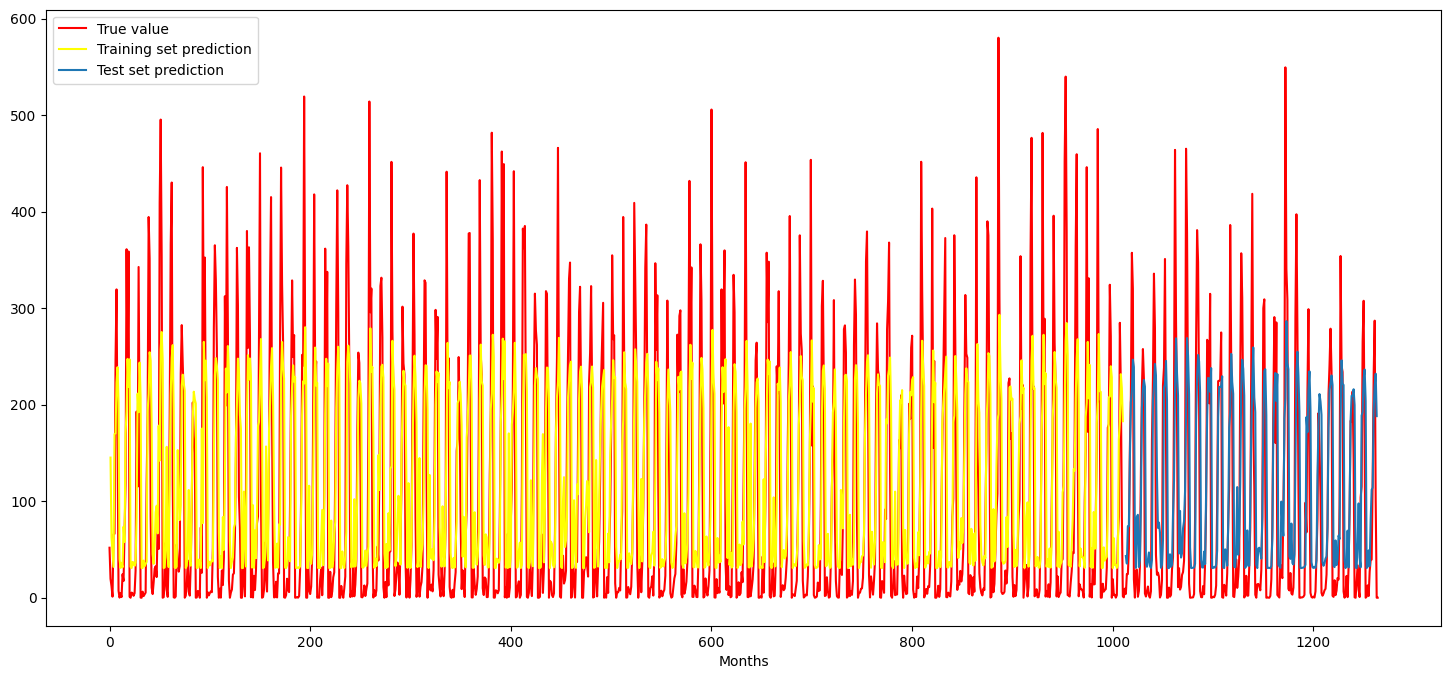

In [21]:
plt.figure(figsize=(18, 8))
plt.plot(scaler.inverse_transform(dataset), label="True value", color='red')
plt.plot(train_predict_plot, label="Training set prediction", color='yellow')
plt.plot(test_predict_plot, label="Test set prediction")
plt.xlabel("Months")
plt.legend()
plt.show()

In [22]:
try:
    model = load_model('model.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Error loading model: name 'load_model' is not defined


In [23]:
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.13.1
TensorFlow version: 2.13.0
